# ClusterMap for STARmap V1_1020

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
import math
from tqdm import tqdm

### Read spots and dapi image

In [2]:
### set file folder
filepath='./datasets/STARmap_V1_1020/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'SUM_dapi.tif')

### read spots
# mat = scipy.io.loadmat(filepath+'allPoints.mat')
spots = pd.read_csv(filepath+'STARmap_V1_spot_meta_cellid.csv')

# ### read gene id in mat['allReads']
# gene=mat['allReads'].astype('int')
spots['gene']=spots['gene']-min(spots['gene'])+1

# ### get gene annotation for barcode in spots['gene']
genes=pd.read_csv(filepath+'BY1_genelist.csv',header=None)

In [3]:
### set radius parameters
xy_radius=50

Text(0.5, 1.0, 'raw data')

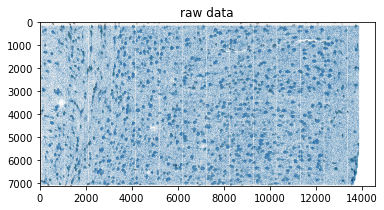

In [4]:
### overview
plt.figure()
length=1000
plt.imshow(dapi,cmap='Greys')
plt.scatter(spots['spot_location_1'],spots['spot_location_2'],s=0.00005)
plt.title('raw data')

### instantiate model

In [5]:
num_gene=np.max(spots['gene'])

gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=True)
model.spots['clustermap']=-1

### split data into small tiles if input is large

In [6]:
###split
img = dapi
window_size=1400
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 45 tiles


Text(0.5, 1.0, 'splitted tile: 35')

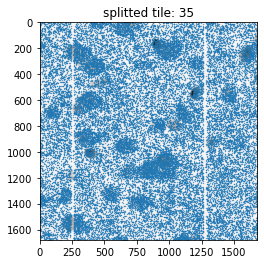

In [7]:
###plot a tile
tile_num=35
plt.figure(figsize=(4,4))
plt.imshow(out.loc[tile_num,'img'],cmap='Greys')

plt.scatter(out.loc[tile_num,'spots']['spot_location_1'],
            out.loc[tile_num,'spots']['spot_location_2'],s=0.1)
plt.title(f'splitted tile: {tile_num}')

In [14]:
%%time

### process each tile
pct_filter=0.3
for tile_num in range(out.shape[0]):
    print(f'tile: {tile_num}')
    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']
    
    ### instantiate model
    model_tile = ClusterMap(spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=False)
    
    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3,pct_filter=pct_filter)
    
    ### segmentation
    model_tile.min_spot_per_cell=5
    model_tile.segmentation(cell_num_threshold=0.9,dapi_grid_interval=3,add_dapi=True,use_genedis=True)
    
    ### plot cell segmentation results in spots (colored by cells)
    model_tile.plot_segmentation(figsize=(4,4),s=0.05,plot_with_dapi=True,plot_dapi=True, show=False)
#     plt.scatter(model_tile.cellcenter[:,1],model_tile.cellcenter[:,0],c='r',s=3)
    
    ### stitch tiles together
    model_tile.spots.loc[model_tile.spots['clustermap']>=0,'clustermap']+=max(model.spots['clustermap'])+1
    model.spots.loc[model_tile.spots['index'],'clustermap']=list(model_tile.spots['clustermap'])
    

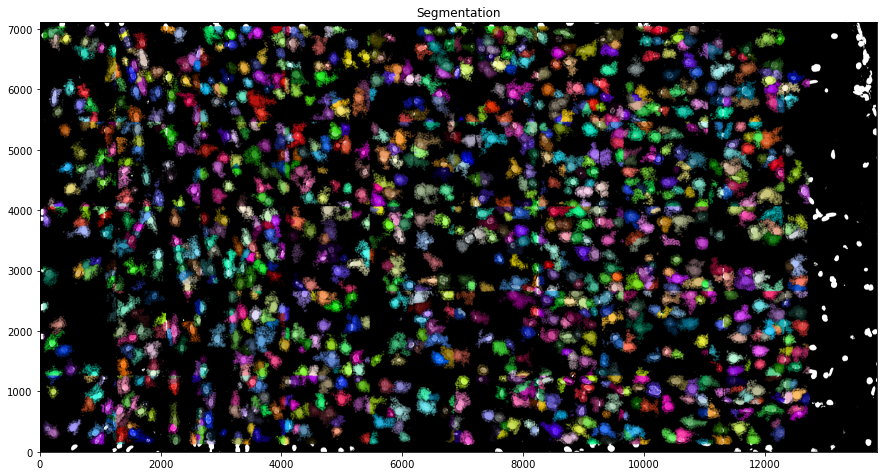

In [19]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(15,8),s=0.005,plot_with_dapi=False,plot_dapi=True, show=False)
plt.show()

### Save cell segmentation results

In [10]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

### Perform cell typing (based on Scanpy package)

In [6]:
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots
# model.cellcenter = np.genfromtxt(filepath+"cellcenter.csv", delimiter=',')

In [7]:
model.spots

,spot_location_1,spot_location_2,spot_location_3,spot_image_position,gene,spot_cell_id,clustermap
0,59,554,1,V1,979,-2,-1.0
1,73,478,1,V1,492,-2,38.0
2,73,665,1,V1,340,-2,-1.0
3,79,321,1,V1,548,-2,38.0
4,80,197,1,V1,979,-2,-1.0
...,...,...,...,...,...,...,...
1281106,13657,6731,36,V1,468,1473,-1.0
1281107,13724,6548,36,V1,57,1399,-1.0
1281108,13733,6393,36,V1,722,1339,-1.0
1281109,13580,6807,37,V1,911,1457,-1.0


In [8]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

cluster_method='leiden'

In [9]:
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/Users/yichunhe/opt/anaconda3/envs/workEnv/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


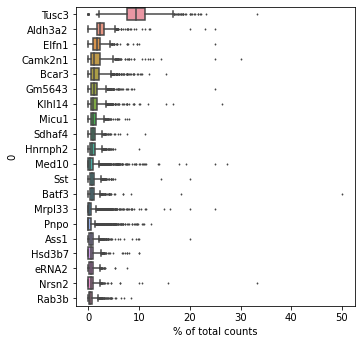

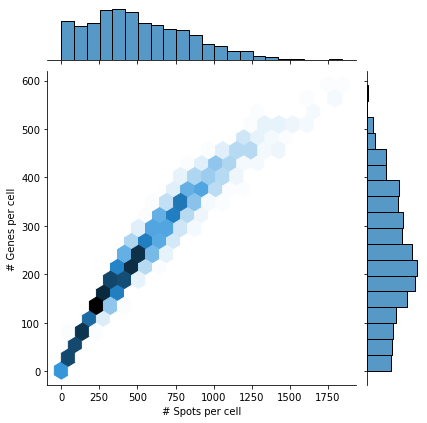

Leiden clustering


In [10]:
model.cell_typing(cluster_method=cluster_method)

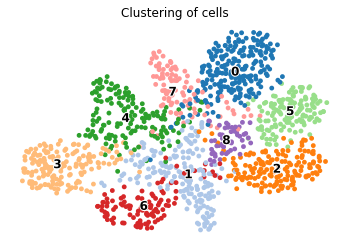

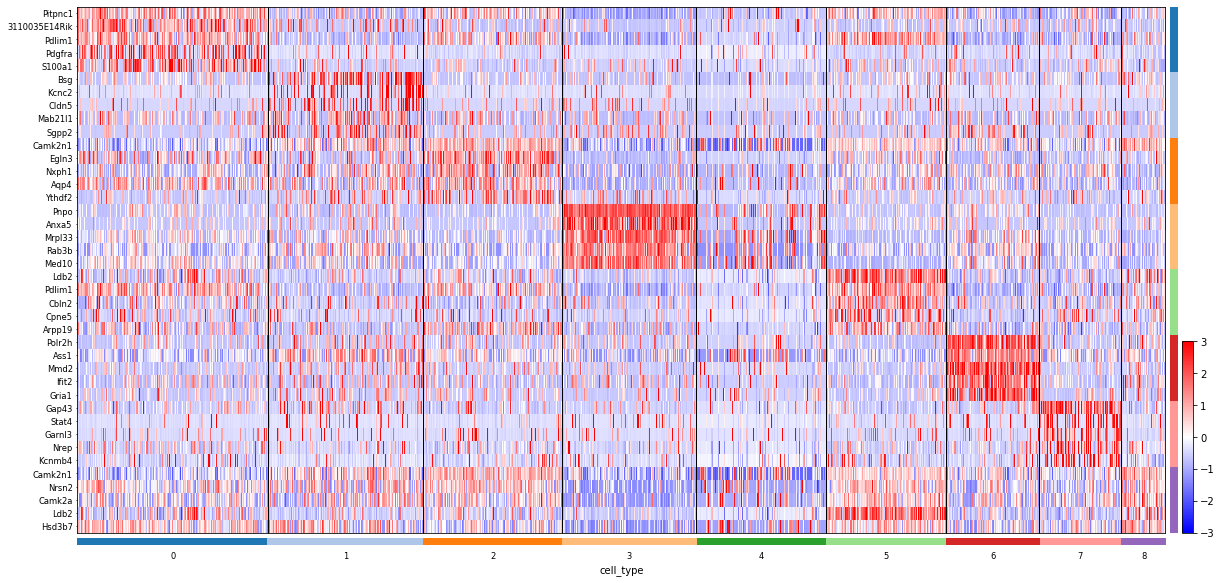

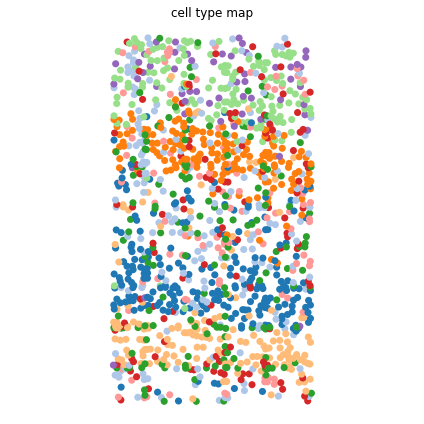

In [11]:
cluster_pl=model.plot_cell_typing()

In [12]:
model.map_cell_type_to_spots(cellid)

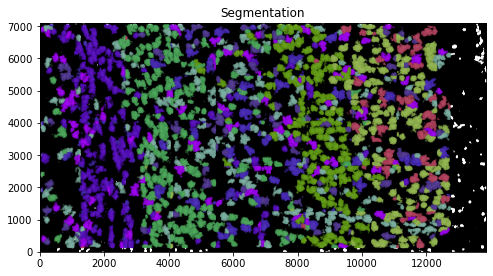

In [13]:
### plot cell segmentation results in spots (colored by cells)
model.plot_segmentation(figsize=(8,8),method='cell_type',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False)
plt.show()